In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Tensor:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = np.zeros_like(data)
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def shape(self):
        return self.data.shape

    def __repr__(self):
        return str(self.data)
    
    def __add__(self, other):
        out = Tensor(self.data + other.data, (self, other), '+', label=f'{self.label}+{other.label}')

        def _backward():
            self.grad += np.broadcast_to(out.grad, self.data.shape) if self.data.shape == out.grad.shape else np.sum(out.grad, axis=0).reshape(self.data.shape)
            other.grad += np.broadcast_to(out.grad, self.data.shape) if other.data.shape == out.grad.shape else np.sum(out.grad, axis=0).reshape(other.data.shape)

        out._backward = _backward
        return out

    def __sub__(self, other):
        out = Tensor(self.data - other.data, (self, other), '-', label=f'{self.label}-{other.label}')

        def _backward():
            self.grad += np.broadcast_to(out.grad, self.data.shape) if self.data.shape == out.grad.shape else np.sum(out.grad, axis=0).reshape(self.data.shape)
            other.grad -= np.broadcast_to(out.grad, self.data.shape) if other.data.shape == out.grad.shape else np.sum(out.grad, axis=0).reshape(other.data.shape)

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Tensor(self.data * other.data, (self, other), '*', label=f'{self.label}*{other.label}')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return Tensor(-self.data, (self,), 'neg', label=f'-{self.label}')
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, exponent: float):
        data = self.data**exponent
        out = Tensor(data, (self,), f'**{exponent}', label=f'{self.label}**{exponent}')

        def _backward():
            self.grad +=  exponent * self.data ** (exponent - 1) * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def dot(self, other):
        out = Tensor(np.dot(self.data, other.data), (self, other), 'dot', label=f'{self.label} dot {other.label}')

        def _backward():
            self.grad += np.dot(out.grad, other.data.T).reshape(self.data.shape)
            other.grad += np.dot(self.data.T, out.grad).reshape(other.data.shape)

        out._backward = _backward
        return out
    
    def sum(self, axis=None, keepdims=False):
        data = self.data.sum(axis=axis, keepdims=keepdims)
        out = Tensor(data, (self,), 'sum', label=f'{self.label} sum')

        def _backward(axis=axis):
            grad_shape = np.ones_like(self.data.shape)
            if axis is not None:
                if isinstance(axis, int):
                    axis = (axis,)
                for ax in axis:
                    grad_shape[ax] = self.data.shape[ax]
            self.grad += out.grad * np.ones_like(self.data)

        out._backward = _backward
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Tensor(data, (self,), 'relu', label=f'{self.label} relu')

        def _backward():
            self.grad += (self.data > 0) * out.grad

        out._backward = _backward
        return out
    
    def leaky_relu(self):
        data = np.maximum(0.01 * self.data, self.data)
        out = Tensor(data, (self,), 'leaky relu', label=f'{self.label} leaky relu')

        def _backward():
            self.grad += (self.data > 0) * out.grad + (0.01 * (self.data < 0)) * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Tensor(data, (self,), 'tanh', label=f'{self.label} tanh')

        def _backward():
            self.grad += (1 - data**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0 * np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()

In [3]:
class SimpleMLP:
    def __init__(self, layer_sizes):
        self.params = []
        self.layers = len(layer_sizes) - 1

        for i in range(self.layers):
            self.params.append(Tensor(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01))
            self.params.append(Tensor(np.zeros((1, layer_sizes[i+1]))))

    def forward(self, x):
        for i in range(self.layers):
            x = x.dot(self.params[2*i]) + self.params[2*i+1]
            if i < self.layers - 1:
                x = x.leaky_relu()
        self.z = x
        return x

    def backward(self, y):
        loss = ((self.z - y) ** 2).sum() / Tensor(y.data.shape[0]*1.0)  # MSE
        loss.backward()  # Use autograd to calculate gradients

        return loss

    def update(self, lr):
        # Update weights
        for param in self.params:
            param.data -= lr * param.grad

        # Zero grad
        for param in self.params:
            param.grad *= 0

In [4]:
X = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(-1, 1)
Y = np.sin(X)

mlp = SimpleMLP([1,50,20,1])

x_tensor = Tensor(X)
y_tensor = Tensor(Y)

Epoch 100, Loss: 0.0021306339042188446
Epoch 200, Loss: 0.0015480649038957792
Epoch 300, Loss: 0.0015298453372693955
Epoch 400, Loss: 0.002078397633509729
Epoch 500, Loss: 0.001536966179645575
Epoch 600, Loss: 0.0014321321835152072
Epoch 700, Loss: 0.001962598856777084
Epoch 800, Loss: 0.001569260470181888
Epoch 900, Loss: 0.0013473038202782472
Epoch 1000, Loss: 0.0017941726906602355
Epoch 1100, Loss: 0.0016306900958796267
Epoch 1200, Loss: 0.0013387035691444138
Epoch 1300, Loss: 0.0016234609224556802
Epoch 1400, Loss: 0.001609082194629124
Epoch 1500, Loss: 0.0013169619413435647
Epoch 1600, Loss: 0.0014499975352892352
Epoch 1700, Loss: 0.0015719463827832186
Epoch 1800, Loss: 0.001340097679212869
Epoch 1900, Loss: 0.0014424548701551716
Epoch 2000, Loss: 0.0015131392983009318
Epoch 2100, Loss: 0.0013519865012497597
Epoch 2200, Loss: 0.0013065419433518877
Epoch 2300, Loss: 0.0013855616355305884
Epoch 2400, Loss: 0.001376204540230518
Epoch 2500, Loss: 0.00128325134717364
Epoch 2600, Loss: 

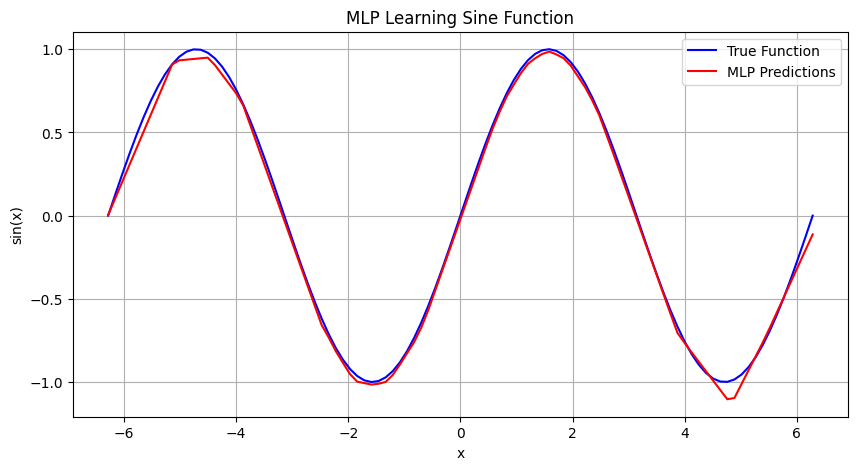

In [8]:
epochs = 5000
learning_rate = 5e-2

for epoch in range(epochs):
    predictions = mlp.forward(x_tensor)

    # Backward pass and loss calculation
    loss = mlp.backward(y_tensor)

    # Update weights and zero grad
    mlp.update(learning_rate)

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.data}')

test_x = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(-1, 1)
test_tensor = Tensor(test_x)
test_predictions = mlp.forward(test_tensor)

plt.figure(figsize=(10, 5))
plt.plot(test_x, np.sin(test_x), label='True Function', color='blue')
plt.plot(test_x, test_predictions.data, label='MLP Predictions', color='red')
plt.legend()
plt.title('MLP Learning Sine Function')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.grid()
plt.show()